In [1]:
import sys 
sys.path.append("../../")

# In[import libs]
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from matplotlib.patches import Arc
from random import randint

from sklearn import metrics 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,log_loss

from sklearn.calibration import CalibratedClassifierCV

from data_filters import scout_service as sct
from maths.pitch import dictCoordenadas36, draw_pitch, set_shots_on_target_coordinates
from maths.trig import calculate_distance_angles
#from plots import *
from calls import get_jogos_sde

from prettytable import PrettyTable
import math
import time

import gatomestre_sde as sde

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Retorna informações dos atletas
def get_atletas_sde(atleta_id):
    url = f'/atletas/{atleta_id}'
    try:
        response = sde._request_sde(url, False)
    except:
        url = f'/tecnicos/{atleta_id}'
        try:
            response = sde._request_sde(url, False)
        except:
            return None
    df = pd.DataFrame.from_dict(response).T
    df = sde.pivot_column(df, 'posicao')
    return df

In [3]:
def atualiza_informacoes_atleta(df):
    df_atletas = pd.DataFrame()
    for atleta_id in df['atleta_id'].unique():
        result = get_atletas_sde(int(atleta_id))
        df_atletas = pd.concat([df_atletas, result]).reset_index(drop=True)
    resultado = df.merge(df_atletas, how='left', on='atleta_id')
    return resultado

## Dataset

Dataset é coletado a partir de dados do Scout Service, referentes aos torneios no último biênio (2020/2021):

<code>
torneios = ['AmistososSelecao', 'Baiano', 'Brasileiro', 'BrasileiroB', 'BrasileiroFeminino', 'Carioca', 'CopaAmerica', 
            'CopaBrasil', 'CopaNordeste', 'CopaSPJunior', 'EliminatoriasCopaMundo', 'EuroCopa', 'Gaucho', 'Libertadores', 
            'Mineiro', 'OlimpiadasFutebolFeminino', 'OlimpiadasFutebolMasculino', 'Paulista', 'Pernambucano', 'PreLibertadores', 
            'RecopaSulAmericana', 'SulAmericana', 'SuperCopaBrasil']</code>

In [4]:
# In[Running]
raw = pd.read_csv('database/2023/scout_service/events/Eventos_All.gz',compression='gzip', low_memory=False)
#df.isnull().sum()
# lidar com Nan
raw = raw.fillna(0)
# # limpar colunas
del raw['index']
#del raw['Unnamed: 0']
# dados que precisam ser type <int>
raw = raw.astype({'PosicaoLance': 'int32', 'TempoPartida': 'int32', 'Jogador_Posicao': 'int32', 'atleta_id': 'int32', 'Rodada': 'int32','Codigo':'int32', 'clube_id':'int32','oponente_id':'int32'})
# eliminar lances inexistentes no dataframe
raw = raw[raw['PosicaoLance']!=-1]
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244629 entries, 0 to 2253477
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Codigo                 int32  
 1   Lance                  object 
 2   Nome                   object 
 3   Ocorrencia             object 
 4   PosicaoLance           int32  
 5   TempoPartida           int32  
 6   TimestampStr           object 
 7   atleta_id              int32  
 8   apelido                object 
 9   sigla                  object 
 10  Jogador_Posicao        int32  
 11  Partida_CodigoExterno  float64
 12  tempo                  object 
 13  tempo_2                object 
 14  clube_id               int32  
 15  Codigo_SCT             float64
 16  Partida_CodigoInterno  float64
 17  Rodada                 int32  
 18  Torneio                object 
 19  Edicao                 float64
 20  oponente_id            int32  
 21  home_dummy             float64
dtypes: float64(5), int

In [5]:
raw.head(3)

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,tempo,tempo_2,clube_id,Codigo_SCT,Partida_CodigoInterno,Rodada,Torneio,Edicao,oponente_id,home_dummy
0,74,Passe,Completo,PT33M50S,14,2,2023-05-04T01:04:50,69034,Paulinho,MEC,...,33:50,01:04:50,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0
1,74,Passe,Completo,PT34M47S,22,2,2023-05-04T01:04:46,69034,Paulinho,MEC,...,34:47,01:04:46,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0
2,74,Passe,Completo,PT35M31S,33,2,2023-05-04T01:04:44,69034,Paulinho,MEC,...,35:31,01:04:44,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0


In [6]:
# padronizar colunas de acordo com pipeline cartola FC
raw = raw.rename(columns={'Jogador_Posicao':'posicao_id',
                         'Rodada':'rodada_id',
                         'oponente_id':'adversario_id',
                         'Partida_CodigoExterno': 'match_id',
                         'Partida_CodigoInterno':'match_id_sct'})

raw = raw.drop_duplicates(keep='last').reset_index(drop=True)
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371196 entries, 0 to 371195
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Codigo         371196 non-null  int32  
 1   Lance          371196 non-null  object 
 2   Nome           371196 non-null  object 
 3   Ocorrencia     371196 non-null  object 
 4   PosicaoLance   371196 non-null  int32  
 5   TempoPartida   371196 non-null  int32  
 6   TimestampStr   371196 non-null  object 
 7   atleta_id      371196 non-null  int32  
 8   apelido        371196 non-null  object 
 9   sigla          371196 non-null  object 
 10  posicao_id     371196 non-null  int32  
 11  match_id       371196 non-null  float64
 12  tempo          371196 non-null  object 
 13  tempo_2        371196 non-null  object 
 14  clube_id       371196 non-null  int32  
 15  Codigo_SCT     371196 non-null  float64
 16  match_id_sct   371196 non-null  float64
 17  rodada_id      371196 non-nul

## Transformação das Coordenadas
#### Recebemos do ScoutService os lances posicionados em apenas 36 quadrantes. Precisamos:
- Randomizar as coordenadas (x,y) dentro do quadrante para gerar variância 
- Calcular a distância de cada coordenada em relação ao gol
- Calcular o ângulo (degrees e radians) da coordenada em relação ao gol

In [7]:
# transformar coordenadas centralizadas nos 36 quadrantes em coordenadas (x,y) com variância randomizada
# filtragem por finalizações
df_shots_on_target = set_shots_on_target_coordinates(raw,'xGOT')
df_shots_on_target.to_csv('Shots_on_target.csv')
print(df_shots_on_target, df_shots_on_target.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2787 entries, 231 to 371025
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Codigo            2787 non-null   int64  
 1   Lance             2787 non-null   object 
 2   Nome              2787 non-null   object 
 3   Ocorrencia        2787 non-null   object 
 4   PosicaoLance      2787 non-null   int64  
 5   TempoPartida      2787 non-null   int64  
 6   TimestampStr      2787 non-null   object 
 7   atleta_id         2787 non-null   int64  
 8   apelido           2787 non-null   object 
 9   sigla             2787 non-null   object 
 10  posicao_id        2787 non-null   int64  
 11  match_id          2787 non-null   float64
 12  tempo             2787 non-null   object 
 13  tempo_2           2787 non-null   object 
 14  clube_id          2787 non-null   int64  
 15  Codigo_SCT        2787 non-null   float64
 16  match_id_sct      2787 non-null   floa

## Avaliação de outros modelos

- SVM
- KNN
- Naive Bayes
- Logistic Regression

Vamos criar um método que recebe um modelo com uma série de parametrizações e procede com Validação Cruzada para cada um desses modelos, de modo a atingirmos a otimização ideal, evitando overfitting nos dados de treinamento e nos dados de teste

In [8]:
def avaliar_modelos(tipo, parametrizacoes, X, y, resultados):

    """Avalia modelos utilizando 10-fold cross-validation

    Essa função recebe um conjunto de parametrizações, um conjunto de 
    atributos e labels e popula uma estrutura de resultados.    
    """
    # Vamos iterar sobre cada parametrização no dicionário.
    # Ao adicionar .items(), vamos iterar sobre todos os pares
    # (chave, valor) do dicionário:
    for nome, modelo in parametrizacoes.items():
        seed = 0
        np.random.seed(seed)
        print("Avaliando parametrização:", nome)
        print("\tProgresso: [", end = '')
        # Vamos padronizar nossos dados com o StandardScaler
        #scaler = StandardScaler()
        # StratifiedKFold irá separar nossos dados em K splits estratificados,
        # ou seja, K splits onde a distribuição das classes será igual ao dos
        # dados originais. Shuffle irá embaralhar nossos dados antes de efetuar
        # o split.
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        # As 3 listas a seguir irão armazenar as métricas de acurácia, recall e
        # área sob a curva ROC de cada fold. Usaremos essas listas para calcular
        # a média de cada métrica.
        accs_scores = []
        recall_scores = []        
        roc_aucs_scores = []
        # O método split irá retornar índices que nós usaremos pra indexar os
        # conjuntos X e y. Por exemplo, se tivermos 10 exemplos no nosso conjunto
        # de dados e quisermos realizar 5 splits, uma possível divisão de splits
        # seria [1, 2], [0, 3], [4, 9], [5, 8], [6, 7]. Então para cada iteração
        # do for, o método split separa 1 desses splits para treino e o resto 
        # para teste (ex. teste = [1, 2], treino = [0, 3, 4, 9, 5, 8, 6, 7]). O 
        # loop for acaba depois que todos os splits forem usados para teste.        
        for treino, teste in cv.split(X, y):
            # Fit do modelo nos dados de treino:
            modelo.fit(X[treino], y[treino])
            # Calculo das métricas do fold. Armazenamos elas nas listas que
            # definimos anteriormente.
            y_pred = modelo.predict(X[teste])                    
            accs_scores.append(accuracy_score(y[teste], y_pred))
            recall_scores.append(recall_score(y[teste], y_pred, average=None))
            # y_score calculado como especificado em:
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
            y_score = modelo.predict_proba(X[teste])[:, 1]
            roc_aucs_scores.append(roc_auc_score(y[teste], y_score))
            # Barra de progresso             
            print("#", end = '')
        print("]")
        # Adicionando média dos folds aos resultados:
        resultados['Algoritmo'].append(tipo)
        resultados["Parametrização"].append(nome)
        resultados["Acuracia"].append(np.mean(accs_scores))
        resultados["Recall"].append(np.mean(recall_scores))
        resultados["Roc_auc"].append(np.mean(roc_aucs_scores))

### Parâmetros

Introduzimos X e y no método <code>avaliar_modelos()</code>, com um dicionário que, para cada modelo, vai avaliar:

- Parametrização
- Acuracia
- Recall
- Roc_auc

In [12]:
X = df_shots_on_target[['Distance Ot','Angle Radians Ot','header_ot']].copy().values
y = df_shots_on_target[['Goal']].values.reshape(-1)


print(X.shape)
print(y.shape)

resultados = {
    "Algoritmo" :[],
    "Parametrização" :[],
    "Acuracia" :[],
    "Recall" :[],
    "Roc_auc" :[]
}

# definindo as diferentes configurações para o método Regressão Logística
modelos_logis_regression = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression, fit_intercetp=False": LogisticRegression(fit_intercept=False),
    "Logistic Regression, Weights Balanced": LogisticRegression(class_weight='balanced',solver='lbfgs'),
}

avaliar_modelos('Logistic Regression', modelos_logis_regression, X, y, resultados)

# # definindo as diferentes configurações para o método SVC
# modelos_svm = {
#     "Kernel rbf, gamma auto": SVC(kernel = 'rbf', gamma='auto', probability=True),
#     "Kernel linear": SVC(kernel = 'linear', probability=True),
#     "Kernel sigmoide": SVC(kernel = 'sigmoid', probability=True),
#     "Kernel polinomial grau 2": SVC(kernel = 'poly', degree=2, probability=True),
#     "Kernel polinomial grau 3": SVC(kernel = 'poly', degree=3, probability=True)
# }

# avaliar_modelos('SVM', modelos_svm, X, y, resultados)

modelos_xgboost = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost with max_depth=3, learning_rate=0.1": XGBClassifier(max_depth=3, learning_rate=0.1),
    "XGBoost with subsample=0.7, colsample_bytree=0.8": XGBClassifier(subsample=0.7, colsample_bytree=0.8),
    "XGBoost with scale_pos_weight for imbalanced": XGBClassifier(scale_pos_weight=3)
    # ... add more configurations as needed
}
avaliar_modelos('XGBoost', modelos_xgboost, X, y, resultados)

# definindo as diferentes configurações para o método NB
modelos_gaussian = {
    "Var smoothing 1e-9": GaussianNB(var_smoothing=1e-9),
    "Var smoothing 1e-8": GaussianNB(var_smoothing=1e-8),
    "Var smoothing 1e-7": GaussianNB(var_smoothing=1e-7),
    "Var smoothing 1e-6": GaussianNB(var_smoothing=1e-6),
    "Var smoothing 1e-5": GaussianNB(var_smoothing=1e-5)
}

avaliar_modelos("GaussianNB", modelos_gaussian, X, y, resultados)

# definindo as diferentes configurações para o método KNN

modelos_knn = {
    "N=3": KNeighborsClassifier(n_neighbors=3),
    "N=5": KNeighborsClassifier(n_neighbors=5),
    "N=7": KNeighborsClassifier(n_neighbors=7),
    "N=9": KNeighborsClassifier(n_neighbors=9),
    "N=11": KNeighborsClassifier(n_neighbors=11),
}

avaliar_modelos("KNN", modelos_knn, X, y, resultados)

resultados

(2787, 3)
(2787,)
Avaliando parametrização: Logistic Regression
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, fit_intercetp=False
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, Weights Balanced
	Progresso: [##########]
Avaliando parametrização: XGBoost Default
	Progresso: [##########]
Avaliando parametrização: XGBoost with max_depth=3, learning_rate=0.1
	Progresso: [##########]
Avaliando parametrização: XGBoost with subsample=0.7, colsample_bytree=0.8
	Progresso: [##########]
Avaliando parametrização: XGBoost with scale_pos_weight for imbalanced
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-9
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-8
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-7
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-6
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-5
	Progresso: [##########]
Avaliando parametrizaç

{'Algoritmo': ['Logistic Regression',
  'Logistic Regression',
  'Logistic Regression',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'KNN',
  'KNN',
  'KNN',
  'KNN',
  'KNN'],
 'Parametrização': ['Logistic Regression',
  'Logistic Regression, fit_intercetp=False',
  'Logistic Regression, Weights Balanced',
  'XGBoost Default',
  'XGBoost with max_depth=3, learning_rate=0.1',
  'XGBoost with subsample=0.7, colsample_bytree=0.8',
  'XGBoost with scale_pos_weight for imbalanced',
  'Var smoothing 1e-9',
  'Var smoothing 1e-8',
  'Var smoothing 1e-7',
  'Var smoothing 1e-6',
  'Var smoothing 1e-5',
  'N=3',
  'N=5',
  'N=7',
  'N=9',
  'N=11'],
 'Acuracia': [0.7628232897552925,
  0.7620999974214178,
  0.6440769964673423,
  0.7291057476599365,
  0.753499136174931,
  0.7208555736056317,
  0.6630798586936901,
  0.7183466130321549,
  0.7183466130321549,
  0.7183466130321549,
  0.7183466130321549,
  0.7194

In [13]:
# resultados
resultados_df = pd.DataFrame.from_dict(resultados)
resultados_df

,Algoritmo,Parametrização,Acuracia,Recall,Roc_auc
0,Logistic Regression,Logistic Regression,0.762823,0.514443,0.708266
1,Logistic Regression,"Logistic Regression, fit_intercetp=False",0.762100,0.520156,0.708846
2,Logistic Regression,"Logistic Regression, Weights Balanced",0.644077,0.679767,0.708134
3,XGBoost,XGBoost Default,0.729106,0.557698,0.673766
4,XGBoost,"XGBoost with max_depth=3, learning_rate=0.1",0.753499,0.511015,0.710393
5,XGBoost,"XGBoost with subsample=0.7, colsample_bytree=0.8",0.720856,0.553300,0.663077
6,XGBoost,XGBoost with scale_pos_weight for imbalanced,0.663080,0.596338,0.672608
7,GaussianNB,Var smoothing 1e-9,0.718347,0.546481,0.695599
8,GaussianNB,Var smoothing 1e-8,0.718347,0.546481,0.695599
9,GaussianNB,Var smoothing 1e-7,0.718347,0.546481,0.695599


In [14]:
best_roc_aucs = resultados_df.groupby(["Algoritmo"])["Roc_auc"].agg([ ("Roc_auc", max)])
best_roc_aucs

,Roc_auc
Algoritmo,
GaussianNB,0.695649
KNN,0.679732
Logistic Regression,0.708846
XGBoost,0.710393


In [15]:
melhores_parametrizacoes = {}
for linha in best_roc_aucs.itertuples():
    print(linha)
    tipo_algo = linha[0]
    melhor_valor = linha[1]    
    # Colocamos iloc[0] no final para pegar a primeira ocorrencia, pois podemos
    # ter mais de uma mesma parametrização com mesmo valor roc_aoc:
    melhores_parametrizacoes[tipo_algo] = resultados_df.query(
        "(Algoritmo==@tipo_algo) & (Roc_auc==@melhor_valor)").iloc[0]["Parametrização"]
    
    print("Melhor parametrização do", tipo_algo, "=", melhores_parametrizacoes[tipo_algo])

    # parâmetros dos melhores modelos
melhor_logis_regression = modelos_logis_regression[melhores_parametrizacoes["Logistic Regression"]]
melhor_gaussiannb = modelos_gaussian[melhores_parametrizacoes["GaussianNB"]]
melhor_KNN = modelos_knn[melhores_parametrizacoes["KNN"]]
melhor_xgboost = modelos_xgboost[melhores_parametrizacoes["XGBoost"]]

Pandas(Index='GaussianNB', Roc_auc=0.6956489228716899)
Melhor parametrização do GaussianNB = Var smoothing 1e-5
Pandas(Index='KNN', Roc_auc=0.6797319601110242)
Melhor parametrização do KNN = N=11
Pandas(Index='Logistic Regression', Roc_auc=0.7088459577129452)
Melhor parametrização do Logistic Regression = Logistic Regression, fit_intercetp=False
Pandas(Index='XGBoost', Roc_auc=0.7103934051787462)
Melhor parametrização do XGBoost = XGBoost with max_depth=3, learning_rate=0.1


## Modelo Escolhido - XGBoost
Melhor parametrização XGBoost with max_depth=3, learning_rate=0.1

## O vetor xG

#### Criamos o modelo xG para o campeonato desejado

Criemos um método que recebe o dataset de finalizações para treino e teste. Este método aceita filtragem por campeonato.

In [89]:
def logistic_regression_xG(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio)&(df['Edicao']==edicao)]

    # inicializamos o dataset
    dataset = df[['Goal', 'Distance_Ot','Angle Radians Ot']].copy()
    # split em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal',axis=1), 
                                                        dataset['Goal'], test_size=0.20, 
                                                        random_state=10)
    # treinar modelo
    logistic_model = LogisticRegression(fit_intercept=False,solver='lbfgs')

    # Fit do modelo nos dados de treino:         
    logistic_model.fit(X_train, y_train)

    # calcular probabilidades
    y_pred = logistic_model.predict_proba(X_test)[:,1]
    # para obter probabilidades de todas as linhas do dataset
    y_hat = logistic_model.predict_proba(dataset.drop('Goal',axis=1))[:,1]
    y_hat.shape
    ## VETOR xG - adicionar y_probs como uma coluna ao dataframe original
    df['xGOT'] = y_hat
    return df

In [16]:
def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

    # Inicializar o dataset
    dataset = df[['Goal', 'Distance Ot','Angle Radians Ot','header_ot']].copy()

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), 
                                                        dataset['Goal'], test_size=0.20, 
                                                        random_state=10)

    # Inicializar o modelo XGBoost
    xgb_model = XGBClassifier(max_depth=3, learning_rate=0.1)

    # Treinar o modelo
    xgb_model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = xgb_model.predict(X_test)

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Fazer previsões no conjunto completo
    y_probs = xgb_model.predict_proba(dataset.drop('Goal', axis=1))[:, 1]

    # Adicionar probabilidades xG ao DataFrame original
    df['xGOT'] = y_probs

    return df

# def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):

#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     dataset = df[['Goal', 'Distance Ot','Angle Radians Ot','header_ot']].copy()
#     dataset['Distance_Ot*Angle_Ot'] = dataset['Distance Ot'] * dataset['Angle Radians Ot']

#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), dataset['Goal'], test_size=0.20, random_state=10)

#     xgb_model = XGBClassifier(max_depth=3, learning_rate=0.1)
#     xgb_model.fit(X_train, y_train)

#     calibrated_clf = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
#     calibrated_clf.fit(X_train, y_train)

#     y_pred = xgb_model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     logloss = log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
#     auc = roc_auc_score(y_test, y_pred)

#     print("Accuracy:", accuracy)
#     print("Log Loss:", logloss)
#     print("AUC:", auc)

#     y_probs = calibrated_clf.predict_proba(dataset.drop('Goal', axis=1))[:, 1]
#     df['xGOT'] = y_probs

#     return df


## Opções de treinamento

#### Podemos:

- Treinar o modelo apenas com dados de um torneio desejado, usando um método que recebe torneio
- Treinar o modelo com todos os torneios, e filtrar apenas o vetor do recorte desejado. Por ora, seguimos com esta opção

In [17]:
# treinar modelo com dados do brasileirao de 2021
#df_brasileiro = logistic_regression_xG(df, 'Brasileiro', 2021, filtrar=True)

# treinar xG com dados de todos os torneios
#df_geral = logistic_regression_xG(df=df_shots_on_target)
df_geral = xgboost_xG(df=df_shots_on_target)

# filtrar apenas lances do campeonato brasileiro
df_brasileiro = df_geral.loc[(df_shots_on_target['Torneio']=='Brasileiro')&(df_shots_on_target['Edicao']==2023)]

Accuracy: 0.7544802867383512


In [384]:
# df_geral.to_csv('xG.csv', index=False)

In [18]:
print (df_brasileiro.info(),df_brasileiro)

# df_brasileiro = atualiza_informacoes_atleta(df_brasileiro)

# print (df_brasileiro.info(),df_brasileiro)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1822 entries, 127256 to 371025
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Codigo            1822 non-null   int64  
 1   Lance             1822 non-null   object 
 2   Nome              1822 non-null   object 
 3   Ocorrencia        1822 non-null   object 
 4   PosicaoLance      1822 non-null   int64  
 5   TempoPartida      1822 non-null   int64  
 6   TimestampStr      1822 non-null   object 
 7   atleta_id         1822 non-null   int64  
 8   apelido           1822 non-null   object 
 9   sigla             1822 non-null   object 
 10  posicao_id        1822 non-null   int64  
 11  match_id          1822 non-null   float64
 12  tempo             1822 non-null   object 
 13  tempo_2           1822 non-null   object 
 14  clube_id          1822 non-null   int64  
 15  Codigo_SCT        1822 non-null   float64
 16  match_id_sct      1822 non-null   f

In [19]:
df_brasileiro = df_brasileiro.rename(columns={'apelido_x':'apelido',
                                             'sigla_x':'sigla',
                                             'altura_x':'altura',
                                             'peso_x':'peso',
                                             'data_nascimento_x':'data_nascimento',
                                             'nome_x':'nome',
                                             'slug_x':'slug',
                                             'macro_x':'macro_x',
                                             'macro_posicao_x':'macro_posicao',
                                             'twitter_x':'twitter'})
                                             
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1822 entries, 127256 to 371025
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Codigo            1822 non-null   int64  
 1   Lance             1822 non-null   object 
 2   Nome              1822 non-null   object 
 3   Ocorrencia        1822 non-null   object 
 4   PosicaoLance      1822 non-null   int64  
 5   TempoPartida      1822 non-null   int64  
 6   TimestampStr      1822 non-null   object 
 7   atleta_id         1822 non-null   int64  
 8   apelido           1822 non-null   object 
 9   sigla             1822 non-null   object 
 10  posicao_id        1822 non-null   int64  
 11  match_id          1822 non-null   float64
 12  tempo             1822 non-null   object 
 13  tempo_2           1822 non-null   object 
 14  clube_id          1822 non-null   int64  
 15  Codigo_SCT        1822 non-null   float64
 16  match_id_sct      1822 non-null   f

In [20]:
df_brasileiro['apelido']

127256    Emerson Negueba
127338          Ceppelini
127396            Endrick
127534        Flaco López
127730      Emerson Ramon
               ...       
370422        Luis Suárez
370442        Lucas Silva
370774           Carballo
370976          Cristaldo
371025               Pepê
Name: apelido, Length: 1822, dtype: object

## Agrupamentos, Agregações e Análises

Agora podemos começar a calcular o XG em razão de time, posição, temporada etc

In [21]:
df_brasileiro.groupby('clube_id')['rodada_id'].unique().count()
rodada = df_brasileiro['rodada_id'].max()
print(rodada)

21


In [22]:
df_brasileiro['rodada_id'].nunique()

21

In [23]:
df_brasileiro[df_brasileiro['clube_id']==262]['rodada_id'].nunique()

20

In [24]:
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1822 entries, 127256 to 371025
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Codigo            1822 non-null   int64  
 1   Lance             1822 non-null   object 
 2   Nome              1822 non-null   object 
 3   Ocorrencia        1822 non-null   object 
 4   PosicaoLance      1822 non-null   int64  
 5   TempoPartida      1822 non-null   int64  
 6   TimestampStr      1822 non-null   object 
 7   atleta_id         1822 non-null   int64  
 8   apelido           1822 non-null   object 
 9   sigla             1822 non-null   object 
 10  posicao_id        1822 non-null   int64  
 11  match_id          1822 non-null   float64
 12  tempo             1822 non-null   object 
 13  tempo_2           1822 non-null   object 
 14  clube_id          1822 non-null   int64  
 15  Codigo_SCT        1822 non-null   float64
 16  match_id_sct      1822 non-null   f

### Trazer Dataset Cartola

In [25]:
# base cartola
#file_name = '/Volumes/Dados/Documents/Code/Apps/gitlab/conteudo/calculadora_gm_backend/calculadora-gato-mestre-backend/database/2022/Cartola_2022_Individual'

file_name = 'database/2023/Cartola_2023_Individual'
df_cartola = pd.read_csv(file_name, compression='gzip', low_memory=False)

# file_name2 = 'Cartola_2022_Individual'
# df_cartola = pd.read_csv(file_name2, compression='gzip', low_memory=False)
# df_cartola.to_csv('Cartola_2022_chat')


In [26]:
df_cartola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15575 entries, 0 to 15574
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nome               15575 non-null  object 
 1   slug               15575 non-null  object 
 2   apelido            15575 non-null  object 
 3   atleta_id          15575 non-null  int64  
 4   rodada_id          15575 non-null  int64  
 5   clube_id           15575 non-null  int64  
 6   posicao_id         15575 non-null  int64  
 7   status_id          15575 non-null  int64  
 8   pontos_num         15575 non-null  float64
 9   preco_num          15575 non-null  float64
 10  variacao_num       15575 non-null  float64
 11  media_num          15575 non-null  float64
 12  jogos_num          15575 non-null  int64  
 13  clube              15575 non-null  object 
 14  posicao            15575 non-null  object 
 15  status_pre         15575 non-null  object 
 16  FF                 155

In [27]:
df_cartola['rodada_id'].nunique()

21

In [28]:
times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
             'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
            'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
            'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

times_dict_r = {v:k for k, v in times_dict.items()}
clubes_ids = list(times_dict.values())

team_icons = {
'Internacional':'![Internacional](https://s.glbimg.com/es/sde/f/organizacoes/2016/05/03/inter65.png)',
'Santos':'![Santos](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/santos_60x60.png)',
'Bragantino':'![Bragantino](https://s.glbimg.com/es/sde/f/organizacoes/2020/01/01/65.png)',
'Flamengo':'![Flamengo](https://s.glbimg.com/es/sde/f/organizacoes/2018/04/09/Flamengo-65.png)',
'Fortaleza':'![Fortaleza](https://s.glbimg.com/es/sde/f/organizacoes/2018/06/10/fortaleza-ec-65px.png)',
'Fluminense':'![Fluminense](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/fluminense_60x60.png)',
'Palmeiras':'![Palmeiras](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/palmeiras_60x60.png)',
'Athlético-PR':'![Athlético-PR](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-65x65.png)',
'Atlético-MG':'![Atlético-MG](https://s.glbimg.com/es/sde/f/organizacoes/2017/11/23/Atletico-Mineiro-escudo65px.png)',
'Corinthians':'![Corinthians](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/30/Corinthians_65.png)',    
'São Paulo':'![São Paulo](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/sao_paulo_60x60.png)',
'América-MG':' ![América-MG](https://s.glbimg.com/es/sde/f/organizacoes/2019/02/28/escudo65_1.png)',
'Cuiabá':' ![Cuiabá](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/16/cuiaba65.png)',
'Coritiba':'![Coritiba](https://s.glbimg.com/es/sde/f/organizacoes/2017/03/29/coritiba65.png)',
'Goiás':'![Goiás](https://s.glbimg.com/es/sde/f/organizacoes/2019/05/01/Goias_65px.png)',
'Botafogo':'![Botafogo](https://s.glbimg.com/es/sde/f/equipes/2013/12/16/botafogo_30x30.png)',
'Grêmio':'![Grêmio](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/gremio_60x60.png)',
'Vasco':'![Vasco](https://s.glbimg.com/es/sde/f/organizacoes/2016/07/29/Vasco-65.png)',
'Bahia':'![Bahia](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/bahia_60x60.png)',
'Cruzeiro':'![Cruzeiro](https://s.sde.globo.com/media/organizations/2021/02/13/cruzeiro_2021.svg)'
        }

### Trazer mando de campo a partir das partidas

In [29]:
# df_merge = df_brasileiro.merge(df_cartola, on='match_id', how='inner')
# df_merge.info()

# xGOT Clubes
Calcular o xGOT agregado por clubes.

- somar o xGOT total
- somar o xGOT por partida
- calcular a média por partida
- comparar total vs média

In [30]:
# xG total
df_clubes_xgot_total = df_brasileiro.groupby(['clube_id'])['xGOT'].agg([('xGOT_total','sum')]).reset_index()
# soma de xG por partida
df_clubes_xgot_match = df_brasileiro.groupby(['clube_id','rodada_id'])['xGOT'].agg([('xGOT_sum','sum')]).reset_index()
# media de xG em todas as partidas
df_clubes_xgot_mean = df_clubes_xgot_match.groupby('clube_id')['xGOT_sum'].agg([('xGOT_mean',np.mean)]).reset_index()
# desvio padrão em todas as partidas
df_clubes_xgot_std = df_brasileiro.groupby('clube_id')['xGOT'].agg([('xGOT_std',np.std)]).reset_index()
# gols
df_clubes_g_total = df_cartola.groupby('clube_id')['G'].agg([('G_total','sum')]).reset_index()
# merge
df_clubes_xgot = df_clubes_xgot_total.merge(df_clubes_xgot_mean, on='clube_id')
# merge again
df_clubes_xgot_vs_g = df_clubes_xgot.merge(df_clubes_g_total, on='clube_id')
# and again
df_clubes_xgot_vs_g = df_clubes_xgot_vs_g.merge(df_clubes_xgot_std, on='clube_id')
#print(df_clubes_xg_vs_g)
# equipes por strings
df_clubes_xgot_vs_g['clube'] = df_clubes_xgot_vs_g['clube_id'].map(times_dict_r)
df_clubes_xgot_vs_g['clube'] = df_clubes_xgot_vs_g['clube'].map(team_icons)
# sort por média xG
df_clubes_xgot_vs_g = df_clubes_xgot_vs_g.sort_values(by='xGOT_total',ascending=False).reset_index(drop=True)[['clube', 'xGOT_mean', 'xGOT_total','G_total']]
df_clubes_xgot_vs_g.dropna()

#df_clubes_xg_vs_g.to_csv(f'conteudo/xG_vs_Goals_R{rodada}.csv', index=False)

df_clubes_xgot_vs_g

,clube,xGOT_mean,xGOT_total,G_total
0,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.349659,28.342833,36.0
1,![Fluminense](https://s.glbimg.com/es/sde/f/or...,1.385046,27.700911,30.0
2,![Fortaleza](https://s.glbimg.com/es/sde/f/org...,1.295677,27.209223,24.0
3,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.286775,27.022274,37.0
4,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.258053,25.161066,34.0
5,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.253450,25.068996,29.0
6,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,1.158675,24.332172,29.0
7,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,1.198299,23.965977,31.0
8,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,1.080134,22.682819,20.0
9,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.031889,21.669666,25.0


# xGOT Atletas

#### Agora vamos fazer o cálculo de xGOT etc sob a perspectiva dos atletas

- Estudo 01. xGOT total
- Estudo 02. xGOT por jogo
- Estudo 03. xGOT vs gols
- Estudo 04. xGOT como medida de eficiência
- Estudo 05. xGOT como medida de potencial

## xGOT Total

In [34]:
df_atletas = df_brasileiro.groupby(['atleta_id', 'apelido','clube_id'])['xGOT'].sum().reset_index()
df_atletas = df_atletas.sort_values(by='xGOT',ascending=False).reset_index(drop=True)
df_atletas = df_atletas[df_atletas['clube_id'].isin(clubes_ids)].reset_index(drop=True)
df_atletas['clube'] = df_atletas['clube_id'].map(times_dict_r)
df_atletas['clube'] = df_atletas['clube'].map(team_icons)

df_atletas = df_atletas[['apelido','clube_id','clube','xGOT']]
df_atletas.head(30)

,apelido,clube_id,clube,xGOT
0,Paulinho,282,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,7.532334
1,Vitor Roque,293,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,7.519016
2,Deyverson,1371,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...,5.609884
3,Cano,266,![Fluminense](https://s.glbimg.com/es/sde/f/or...,5.258285
4,Gabriel,262,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,4.928832
5,Luis Suárez,284,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,4.830091
6,Tiquinho Soares,263,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,4.768246
7,Calleri,276,![São Paulo](https://s.glbimg.com/es/sde/f/org...,4.206795
8,Wesley,283,![Cruzeiro](https://s.sde.globo.com/media/orga...,4.035132
9,Hulk,282,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,3.984762


## Adiconar métricas 

- xG_per_match
- xG_per_shot
- shots_per_goal

In [36]:
df_atletas2 = df_brasileiro.groupby(['atleta_id', 'apelido', 'clube_id']).agg(xGOT_total=('xGOT', 'sum'),
                                                                             shots_total=('Lance', 'count'),
                                                                             jogos_num=('rodada_id', 'nunique'),
                                                                             goals_total=('Goal', 'sum')).reset_index()
df_atletas2['xGOT_per_match']=df_atletas2['xGOT_total']/df_atletas2['jogos_num']
df_atletas2['G_per_match']=df_atletas2['goals_total']/df_atletas2['jogos_num']
df_atletas2['xGOT_per_shot'] = df_atletas2['xGOT_total']/df_atletas2['shots_total']
df_atletas2['shots_per_goal'] = df_atletas2['shots_total']/df_atletas2['goals_total']
df_atletas2['clube'] = df_atletas2['clube_id'].map(times_dict_r)
df_atletas2['clube'] = df_atletas2['clube'].map(team_icons)

xg_total = df_atletas2.sort_values(by='xGOT_total',ascending=False).reset_index(drop=True)

#df_atletas2 = df_atletas2[df_atletas2['clube_id'].isin(clubes_ids)].sort_values(by='xG_total',ascending=False).reset_index(drop=True)

xg_total.head(50)

,atleta_id,apelido,clube_id,xGOT_total,shots_total,jogos_num,goals_total,xGOT_per_match,G_per_match,xGOT_per_shot,shots_per_goal,clube
0,99818,Paulinho,282,7.532334,24,12,7,0.627695,0.583333,0.313847,3.428571,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
1,114802,Vitor Roque,293,7.519016,21,13,10,0.578386,0.769231,0.358048,2.100000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
2,92708,Deyverson,1371,5.609884,17,11,7,0.509989,0.636364,0.329993,2.428571,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...
3,79631,Cano,266,5.258285,21,13,7,0.404483,0.538462,0.250395,3.000000,![Fluminense](https://s.glbimg.com/es/sde/f/or...
4,83257,Gabriel,262,4.928832,13,10,1,0.492883,0.100000,0.379141,13.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
5,69318,Luis Suárez,284,4.830091,24,14,5,0.345006,0.357143,0.201254,4.800000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
6,84042,Tiquinho Soares,263,4.768246,14,9,9,0.529805,1.000000,0.340589,1.555556,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
7,89840,Calleri,276,4.206795,13,8,4,0.525849,0.500000,0.323600,3.250000,![São Paulo](https://s.glbimg.com/es/sde/f/org...
8,105811,Wesley,283,4.035132,15,10,4,0.403513,0.400000,0.269009,3.750000,![Cruzeiro](https://s.sde.globo.com/media/orga...
9,39148,Hulk,282,3.984762,29,14,3,0.284626,0.214286,0.137406,9.666667,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...


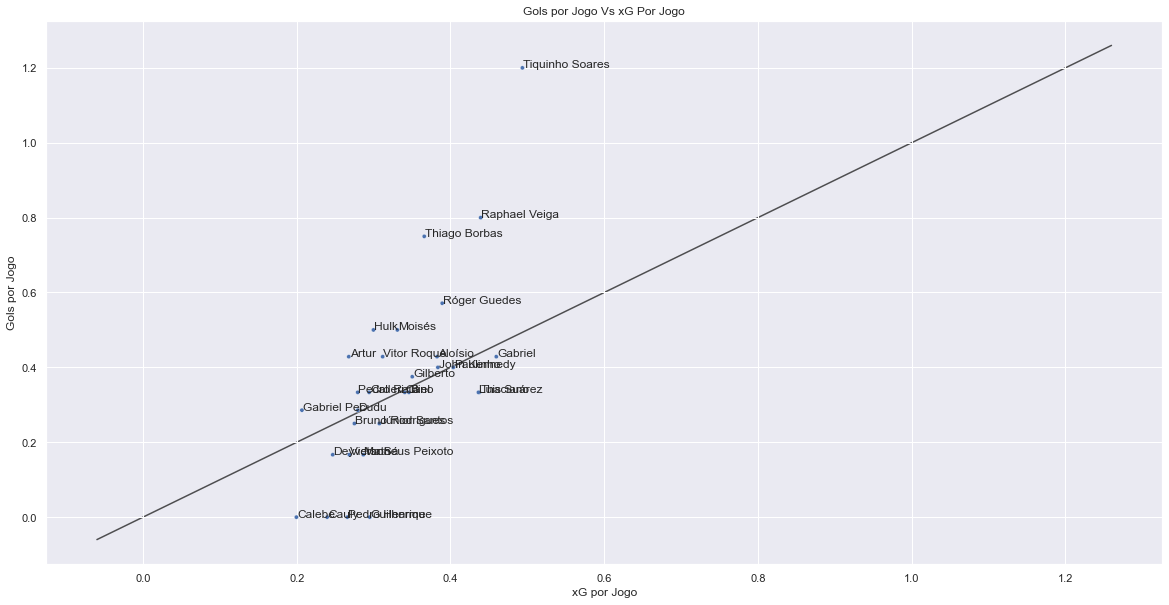

In [378]:
def xG_fit(df,rodada):
    # pegar apenas 30
    df = df.head(30)
    # # obter médias para o tracejado nos eixos
    # xG_geral_mean = np.mean(list(df['xG_geral'].values))
    # xGA_geral_mean = np.mean(list(df['xGA_geral'].values))
    
    #sns.set_theme()
    
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))

    p1 = sns.scatterplot('xGOT_per_match', # Horizontal axis
       'G_per_match', # Vertical axis
       data=df, # Data source
       size = 8,
       legend=False) 
    
    
    plt.title('Gols por Jogo Vs xG Por Jogo')
    # Set x-axis label
    plt.xlabel('xGOT por Jogo')
    # Set y-axis label
    plt.ylabel('Gols por Jogo')
    
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.001, point['y'], str(point['val']))
            #ax.plot([-1,1],[-1,1], 'red', linewidth=10)

            
    label_point(df.xG_per_match, df.G_per_match, df.apelido, plt.gca())  

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    #ax.set_aspect('equal')
    # ax.set_xlim(lims)
    # ax.set_ylim(lims)
    
    #fig.savefig(f'img/G_vs_xG_fit_atletas{rodada}.png')
    
xG_fit(xg_total,rodada)

## xG per match

In [379]:
rodada = df_brasileiro['rodada_id'].max()
PORCENTAGEM_MINIMA_JOGOS = 2.5  # 40%
min_jogos = rodada // PORCENTAGEM_MINIMA_JOGOS
print(min_jogos)

mask = (xg_total['jogos_num']>=int(min_jogos))
xg_per_match = xg_total.loc[mask]
xg_per_match = xg_per_match.sort_values(by='xG_per_match',ascending=False).reset_index(drop=True)

xg_per_match.head(20)

3.0


,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,84042,Tiquinho Soares,263,2.467826,21,5,6,0.493565,1.200000,0.117516,3.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
1,83257,Gabriel,262,3.216875,23,7,3,0.459554,0.428571,0.139864,7.666667,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
2,93108,Mateus Vital,283,1.333061,12,3,0,0.444354,0.000000,0.111088,inf,![Cruzeiro](https://s.sde.globo.com/media/orga...
3,94509,Raphael Veiga,275,2.196487,23,5,4,0.439297,0.800000,0.095499,5.750000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...
4,87470,Thaciano,265,2.626094,30,6,2,0.437682,0.333333,0.087536,15.000000,![Bahia](https://s.glbimg.com/es/sde/f/organiz...
5,69318,Luis Suárez,284,2.618237,21,6,2,0.436373,0.333333,0.124678,10.500000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
6,124251,Deivid Washington,277,1.241499,12,3,2,0.413833,0.666667,0.103458,6.000000,![Santos](https://s.glbimg.com/es/sde/f/organi...
7,99818,Paulinho,282,2.018075,14,5,2,0.403615,0.400000,0.144148,7.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
8,98022,Erick,293,1.192451,10,3,0,0.397484,0.000000,0.119245,inf,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
9,89898,Róger Guedes,264,2.724498,29,7,4,0.389214,0.571429,0.093948,7.250000,![Corinthians](https://s.glbimg.com/es/sde/f/o...


In [380]:
xg_per_match = xg_per_match[['apelido','clube','xG_per_match','G_per_match']]
xg_per_match.head(20).to_csv(f'conteudo/xG_ate_R{rodada}.csv', index=False)

